# Voxel door classifier

<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/samples/test_fast_tpu_pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install -Uqq git+https://github.com/fastai/fastai.git 
!pip install -Uqq fastai --upgrade

     |████████████████████████████████| 194kB 9.1MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 


Start of kernel restart

In [3]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.1MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 1.2MB 38.6MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
Mounted at /content/gdrive


In [4]:
!pip install -Uqq wandb

     |████████████████████████████████| 1.8MB 10.4MB/s 
     |████████████████████████████████| 143kB 52.7MB/s 
     |████████████████████████████████| 174kB 52.2MB/s 
     |████████████████████████████████| 102kB 13.3MB/s 
     |████████████████████████████████| 143kB 61.6MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [1]:
#hide
from fastbook import *
from fastai.callback.wandb import *
from fastai.vision.all import *

In [2]:
import wandb
arch_str = 'resnet50'
wandb.init(project='voxel_door_classifier_4', name=arch_str)

wandb: Currently logged in as: voxelbot (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [7]:
!ls gdrive/MyDrive/Colab\ Notebooks/voxel/door_data



labels.csv  test  train  val


In [4]:
path = Path('./data/dataset4/')


In [5]:
#hide
Path.BASE_PATH = path

In [6]:
path.ls()

(#3) [Path('test'),Path('val'),Path('train')]

In [7]:
bs = 64
arch = models.resnet50
arch_str = 'resnet50'

In [8]:
def get_label(fname):
  return str(fname.parent).split('/')[-1]

In [9]:
data = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    get_y=get_label,
    splitter=GrandparentSplitter(train_name='train', valid_name='val'),
    # splitter=RandomSplitter(seed=42),   
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75) + [Normalize.from_stats(*imagenet_stats)]
)

In [10]:
dls = data.dataloaders(path, bs=bs)

/home/ramin_voxelsafety_com/.cache/bazel/_bazel_ramin_voxelsafety_com/85466f4a4aee3552e073f375ea343d8a/execroot/voxel/bazel-out/k8-fastbuild/bin/third_party/jupyter/jupyter.runfiles/pip_deps_pypi__torch/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


In [11]:
len(dls.train.dataset), len(dls.valid.dataset)

(10449, 2175)

In [12]:
model_cb = SaveModelCallback(monitor='valid_loss', every_epoch=False)
es_cb = EarlyStoppingCallback(monitor='valid_loss', patience=5)
callbacks = [model_cb, es_cb, WandbCallback()]

learner = cnn_learner(dls, arch, metrics=accuracy, concat_pool=False, cbs=callbacks)


/home/ramin_voxelsafety_com/.cache/bazel/_bazel_ramin_voxelsafety_com/85466f4a4aee3552e073f375ea343d8a/execroot/voxel/bazel-out/k8-fastbuild/bin/third_party/jupyter/jupyter.runfiles/pip_deps_pypi__torch/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


/home/ramin_voxelsafety_com/.cache/bazel/_bazel_ramin_voxelsafety_com/85466f4a4aee3552e073f375ea343d8a/execroot/voxel/bazel-out/k8-fastbuild/bin/third_party/jupyter/jupyter.runfiles/pip_deps_pypi__fastai/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0014454397605732083)

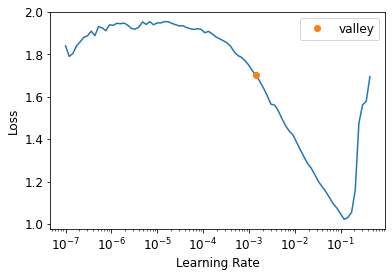

In [13]:
learner.lr_find()

In [14]:
learner.fine_tune(10, base_lr=5.0e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.187253,0.207338,0.954483,01:57


Better model found at epoch 0 with valid_loss value: 0.20733822882175446.


epoch,train_loss,valid_loss,accuracy,time
0,0.057180,0.204820,0.954943,02:33
1,0.074705,0.176538,0.954023,02:35
2,0.071511,0.117085,0.975172,02:35
3,0.054645,0.121258,0.965517,02:35
4,0.050589,0.126101,0.965977,02:35
5,0.044227,0.123890,0.976092,02:35
6,0.031241,0.143232,0.969655,02:36
7,0.029708,0.127308,0.974713,02:35


Better model found at epoch 0 with valid_loss value: 0.20481975376605988.
Better model found at epoch 1 with valid_loss value: 0.17653797566890717.
Better model found at epoch 2 with valid_loss value: 0.11708512902259827.
No improvement since epoch 2: early stopping


In [17]:
save_folder = path.parent/'../models'
os.makedirs(save_folder, exist_ok=true)
os.makedirs(save_folder, exist_ok=true)
save_folder

Path('data/../models')

In [18]:
learner.export(fname=save_folder/f'voxel_door_classifier_model_export_dataset4_{arch_str}.pkl')

In [19]:
interp = ClassificationInterpretation.from_learner(learner, dl=dls.valid)

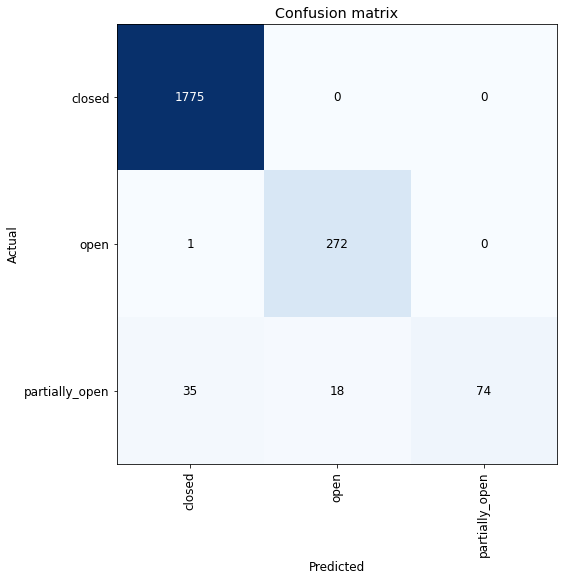

In [20]:
interp.plot_confusion_matrix(figsize=(8,8))

In [21]:
interp.most_confused(min_val=5)

[('partially_open', 'closed', 35), ('partially_open', 'open', 18)]

In [22]:
interp.print_classification_report()

                precision    recall  f1-score   support

        closed       0.98      1.00      0.99      1775
          open       0.94      1.00      0.97       273
partially_open       1.00      0.58      0.74       127

      accuracy                           0.98      2175
     macro avg       0.97      0.86      0.90      2175
  weighted avg       0.98      0.98      0.97      2175



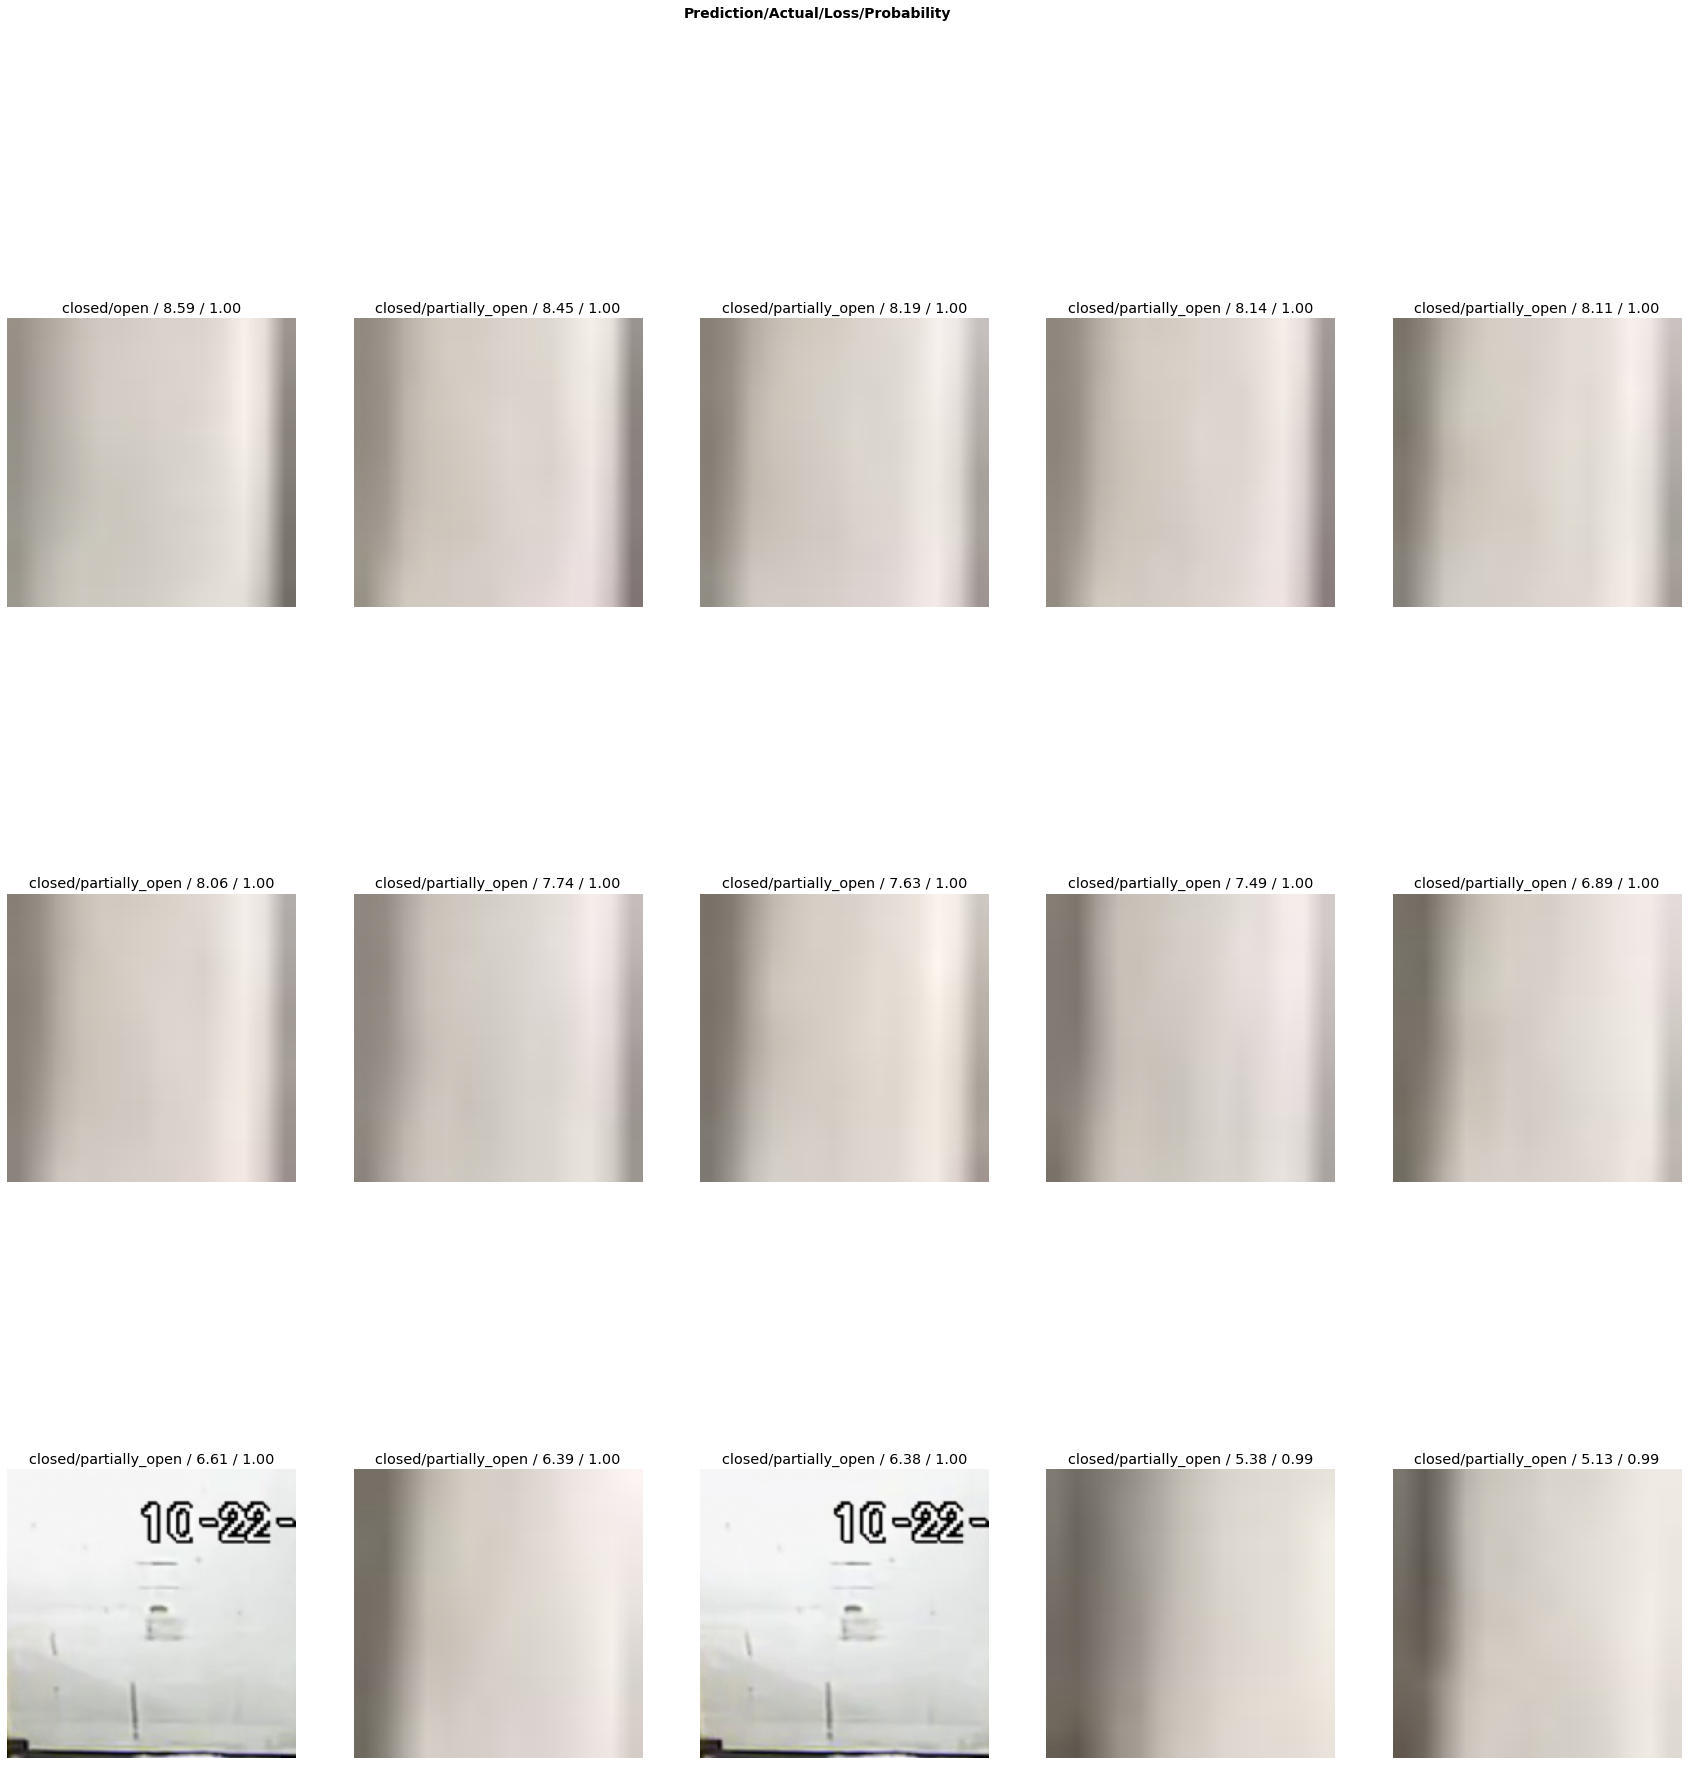

In [23]:
interp.plot_top_losses(15, figsize=(30,30))

In [29]:
dls.train.dataset

(#8780) [(PILImage mode=RGB size=25x56, TensorCategory(0)),(PILImage mode=RGB size=25x56, TensorCategory(0)),(PILImage mode=RGB size=25x56, TensorCategory(0)),(PILImage mode=RGB size=25x56, TensorCategory(0)),(PILImage mode=RGB size=25x56, TensorCategory(0)),(PILImage mode=RGB size=25x56, TensorCategory(0)),(PILImage mode=RGB size=25x56, TensorCategory(0)),(PILImage mode=RGB size=25x56, TensorCategory(0)),(PILImage mode=RGB size=25x56, TensorCategory(0)),(PILImage mode=RGB size=25x56, TensorCategory(0))...]

In [24]:
save_folder = path.parent/'../models'
model_path = save_folder/f'voxel_door_classifier_model_export_dataset4_{arch_str}.pkl'
learn = load_learner(model_path, cpu=True)

In [25]:
final_model = learn.model
final_model.eval();

In [27]:
example_input = torch.randn(1, 3, 224, 224, requires_grad=False).cpu()
traced_model = torch.jit.trace(final_model, example_input)
traced_model.save(save_folder/f'voxel_door_classifier_dataset4_{arch_str}_traced_model.pth')

In [28]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [29]:
vocab = learn.dls.vocab
vocab

['closed', 'open', 'partially_open']